In [1]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# Logistic Regression
## Binary Classification Using Binary Cross-Entropy (BCE) loss
Load dataset. We will use w1a dataset from LibSVM datasets https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/, which is the same as the one used in one of the labs.

The real machine learning problem that this project focused on is a binary classification problem. Logistic regression is the algorithm used to solve this problem. The optimization problem for the logistic regression is given by
\begin{equation}
  \min_{w \in R^d} f(w) = \min_{w \in R^d} \  \frac{1}{n}\sum_{i=1}^n \big( -y^{(i)}\log(\sigma(w^T x^{(i)}))-(1-y^{(i)})\log(1-\sigma(w^T x^{(i)})) \big)
\end{equation}
where $\sigma : R\rightarrow R$, $\sigma(z) := \frac{1}{1+e^{-z}}$ is the sigmoid function.
Here for any $i$, $1\le i\le n$, the vector $x^{(i)}\in R^d$ is the $i$-th data example, and $y^{(i)}\in\{0,1\}$ is the corresponding label. It is a minimization on the BCE loss.

In [2]:
DATA_TRAIN_PATH = 'data/w1a'

X, y = load_svmlight_file(DATA_TRAIN_PATH)
X = X.toarray()
X = X.T
y = y/2 + 0.5 # change target value from {-1,1} to {0,1}
d = X.shape[0] # number of features
n = X.shape[1] # number of data samples

## Prepare cost and prediction functions

In [3]:
def sigmoid(x, w):
    '''
    Sigmoid function
    x: one data sample
    w: weight vector corresponding to the optimization problem
    '''
    return 1 / (1 + math.exp(-np.dot(x, w)))

In [4]:
def loss(y, X, w):
    '''
    Compute the BCE loss
    X: the full dataset matrix, shape = (n, d)
    y: the corresponding 0 or 1 labels, shape = (n)
    w: weight vector corresponding to the optimization problem, shape = (d)
    '''
    return sum([ -y[i] * math.log(sigmoid(X[:, i], w)) - (1-y[i]) * math.log(1 - sigmoid(X[:, i], w)) for i in range(n)]) / n

In [5]:
'''
The following part is directly copied from the lab notebook (with situable modifications), but it is not the concern of this project.
'''
def accuracy(y1, y2):
    return np.mean(y1 == y2)

def prediction(X, w):
    return (w @ X > 0)

def calculate_accuracy(y, X, w):
    '''
    Compute the training accuracy on the training set (can be called for test set as well).
    X: the full dataset matrix, shape = (n, d)
    y: the corresponding 0 or 1 labels, shape = (n)
    w: weight vector corresponding to the optimization problem, shape = (d)
    '''
    predicted_y = prediction(X, w)
    return accuracy(predicted_y, y)

# Estimating the minimum value of the loss function

As the data is taken from reality (i.e. non-constructed), it is hard to calculate the minimum value of the loss function. A posteriori to the results below, SGD is the best algorithm for optimizing this problem in terms of time measured by computed gradients. As a result, the following runs a SGD algorithm on the problem for a relatively large number of iterations to do an estimation of the minimum value of the loss function.

For $f(w)=\frac{1}{n}\sum_{i=1}^n \big( -y^{(i)}\log(\sigma(w^T x^{(i)}))-(1-y^{(i)})\log(1-\sigma(w^T x^{(i)})) \big)$,
\begin{align*}
\nabla f(w) &= \frac{1}{n}\sum_{i=1}^n \big( y^{(i)}(-1+\sigma(w^T x^{(i)}))x^{(i)}+(1-y^{(i)})\sigma(w^T x^{(i)})x^{(i)} \big) \\
\nabla^2 f(w) &= \frac{1}{n}\sum_{i=1}^n \big( y^{(i)}\sigma(w^T x^{(i)})(1-\sigma(w^T x^{(i)}))x^{(i)}{x^{(i)}}^T+(1-y^{(i)})\sigma(w^T x^{(i)})(1-\sigma(w^T x^{(i)}))x^{(i)}{x^{(i)}}^T \big)\\
&= \frac{1}{n}\sum_{i=1}^n \sigma(w^T x^{(i)})(1-\sigma(w^T x^{(i)}))x^{(i)}{x^{(i)}}^T
\end{align*}

<p>Furthermore, notice that $\nabla^2 f(w)$ is semi-positive symmetric definite, which implies that the function is convex. Moreover, the largest eigenvalue of $\nabla^2 f(w)$ is upper bounded by the average of the largest eigenvalues of $\sigma(w^T x^{(i)})(1-\sigma(w^T x^{(i)}))x^{(i)}{x^{(i)}}^T$ (which is $\sigma(w^T x^{(i)})(1-\sigma(w^T x^{(i)}))||x^{(i)}||^2$). Also, $\sigma(w^T x^{(i)})(1-\sigma(w^T x^{(i)}))\leq\frac{1}{4}$. So $f(w)$ is $L$-smooth, with $L=\frac{1}{4n}\sum_{i=1}^n ||x^{(i)}||^2$.</p>
The $L$ used below doesn't imply that $f(w)$ is not $L'$-smooth for any $L'<L$. $L$ is just a guaranteed upper bound. It has already been calculated above.

In [6]:
def compute_gradient_bc(X_batch, y_batch, w_t, num_data_points):
    '''
    Compute the batch gradient
    X_batch: the batch dataset matrix, shape = (n, d)
    y_batch: the corresponding 0 or 1 labels, shape = (n)
    w_t: weight vector corresponding to the optimization problem, shape = (d)
    num_data_points: equals to n for full gradients, equals to the batch size for stochastic gradients
    '''
    gradient = np.sum([(y_batch[i] * (-1+sigmoid(X_batch[:, i], w_t)) + (1-y_batch[i]) * sigmoid(X_batch[:, i], w_t)) * X_batch[:, i] for i in range(num_data_points)], axis=0) / num_data_points
    return gradient

In [7]:
minimum_loss = [] # initialization

def stochastic_gradient_descent_bc(X, y, lr, max_iter, batch_size=1, trace=False):
    '''
    Stochastic Gradient Descent
    X: the full dataset matrix, shape = (n, d)
    y: the corresponding 0 or 1 labels, shape = (n)
    lr: learning rate (1/L in this project)
    max_iter: maximum number of iterations performed
    batch_size: batch size
    trace: for plotting graphs
    '''
    history = defaultdict(list) if trace else None   
    
    w_t = np.zeros(d) # initialization
    
    for current_iter in range(max_iter):
        i = np.random.choice(n, batch_size, replace=False)
        y_batch, X_batch = y[i], X[:, i]
        gradient = compute_gradient_bc(X_batch, y_batch, w_t, batch_size)
        w_t = w_t - lr * gradient
        if current_iter % 100 == 0:
            loss_value = loss(y, X, w_t)
            print('iteration=%i, loss:%.5f'%(
                    current_iter, loss_value))
        if current_iter % 10 == 0:
            loss_value = loss(y, X, w_t)
            if trace:
                history['loss'].append(loss_value)
                history['difference'].append(loss_value-minimum)
                history['iter'].append(current_iter+1)
                history['gradients_computed'].append((current_iter+1)*batch_size)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, w_t)))
    minimum_loss.append(loss(y, X, w_t))
    return history

L = sum([np.linalg.norm(X[:,i])**2 for i in range (n)]) / (4*n) # an upper bound for smooth coeff. L, which will be used throughout all algorithms

batch_size = 16
history_minimum = stochastic_gradient_descent_bc(X, y, 1/L, 100000, batch_size)
minimum = minimum_loss[0]
print("Estimated minimum: ", minimum)

iteration=0, loss:0.59499
iteration=100, loss:0.21921
iteration=200, loss:0.19556
iteration=300, loss:0.18382
iteration=400, loss:0.17657
iteration=500, loss:0.17055
iteration=600, loss:0.16588
iteration=700, loss:0.16110
iteration=800, loss:0.15759
iteration=900, loss:0.15499
iteration=1000, loss:0.15289
iteration=1100, loss:0.15162
iteration=1200, loss:0.14940
iteration=1300, loss:0.14748
iteration=1400, loss:0.14586
iteration=1500, loss:0.14427
iteration=1600, loss:0.14318
iteration=1700, loss:0.14169
iteration=1800, loss:0.14044
iteration=1900, loss:0.13921
iteration=2000, loss:0.13820
iteration=2100, loss:0.13676
iteration=2200, loss:0.13544
iteration=2300, loss:0.13450
iteration=2400, loss:0.13331
iteration=2500, loss:0.13274
iteration=2600, loss:0.13195
iteration=2700, loss:0.13082
iteration=2800, loss:0.12992
iteration=2900, loss:0.12914
iteration=3000, loss:0.12838
iteration=3100, loss:0.12770
iteration=3200, loss:0.12701
iteration=3300, loss:0.12630
iteration=3400, loss:0.125

iteration=27700, loss:0.08980
iteration=27800, loss:0.08978
iteration=27900, loss:0.08973
iteration=28000, loss:0.08967
iteration=28100, loss:0.08964
iteration=28200, loss:0.08958
iteration=28300, loss:0.08951
iteration=28400, loss:0.08952
iteration=28500, loss:0.08944
iteration=28600, loss:0.08940
iteration=28700, loss:0.08944
iteration=28800, loss:0.08936
iteration=28900, loss:0.08934
iteration=29000, loss:0.08930
iteration=29100, loss:0.08926
iteration=29200, loss:0.08920
iteration=29300, loss:0.08918
iteration=29400, loss:0.08915
iteration=29500, loss:0.08911
iteration=29600, loss:0.08904
iteration=29700, loss:0.08899
iteration=29800, loss:0.08894
iteration=29900, loss:0.08891
iteration=30000, loss:0.08887
iteration=30100, loss:0.08885
iteration=30200, loss:0.08882
iteration=30300, loss:0.08880
iteration=30400, loss:0.08883
iteration=30500, loss:0.08872
iteration=30600, loss:0.08873
iteration=30700, loss:0.08868
iteration=30800, loss:0.08866
iteration=30900, loss:0.08862
iteration=

iteration=55100, loss:0.08333
iteration=55200, loss:0.08337
iteration=55300, loss:0.08329
iteration=55400, loss:0.08324
iteration=55500, loss:0.08324
iteration=55600, loss:0.08325
iteration=55700, loss:0.08320
iteration=55800, loss:0.08318
iteration=55900, loss:0.08318
iteration=56000, loss:0.08313
iteration=56100, loss:0.08317
iteration=56200, loss:0.08312
iteration=56300, loss:0.08308
iteration=56400, loss:0.08307
iteration=56500, loss:0.08308
iteration=56600, loss:0.08307
iteration=56700, loss:0.08301
iteration=56800, loss:0.08300
iteration=56900, loss:0.08300
iteration=57000, loss:0.08297
iteration=57100, loss:0.08297
iteration=57200, loss:0.08293
iteration=57300, loss:0.08291
iteration=57400, loss:0.08290
iteration=57500, loss:0.08291
iteration=57600, loss:0.08287
iteration=57700, loss:0.08287
iteration=57800, loss:0.08286
iteration=57900, loss:0.08283
iteration=58000, loss:0.08282
iteration=58100, loss:0.08281
iteration=58200, loss:0.08282
iteration=58300, loss:0.08282
iteration=

iteration=82500, loss:0.08016
iteration=82600, loss:0.08015
iteration=82700, loss:0.08015
iteration=82800, loss:0.08014
iteration=82900, loss:0.08015
iteration=83000, loss:0.08016
iteration=83100, loss:0.08015
iteration=83200, loss:0.08016
iteration=83300, loss:0.08020
iteration=83400, loss:0.08026
iteration=83500, loss:0.08020
iteration=83600, loss:0.08016
iteration=83700, loss:0.08017
iteration=83800, loss:0.08017
iteration=83900, loss:0.08014
iteration=84000, loss:0.08013
iteration=84100, loss:0.08012
iteration=84200, loss:0.08012
iteration=84300, loss:0.08011
iteration=84400, loss:0.08010
iteration=84500, loss:0.08007
iteration=84600, loss:0.08007
iteration=84700, loss:0.08007
iteration=84800, loss:0.08005
iteration=84900, loss:0.08004
iteration=85000, loss:0.08004
iteration=85100, loss:0.08003
iteration=85200, loss:0.08002
iteration=85300, loss:0.07997
iteration=85400, loss:0.07998
iteration=85500, loss:0.07996
iteration=85600, loss:0.07996
iteration=85700, loss:0.07997
iteration=

# Gradient Descent for binary classification

In [8]:
def gradient_descent_bc(X, y, lr, max_iter, trace=False):
    '''
    Gradient Descent
    X: the full dataset matrix, shape = (n, d)
    y: the corresponding 0 or 1 labels, shape = (n)
    lr: learning rate (1/L in this project)
    max_iter: maximum number of iterations performed
    trace: for plotting graphs
    '''
    history = defaultdict(list) if trace else None    
    
    w_t = np.zeros(d)
    
    for current_iter in range(max_iter):
        gradient = compute_gradient_bc(X, y, w_t, n)
        w_t = w_t - lr * gradient
        if current_iter % 10 == 0:
            loss_value = loss(y, X, w_t)
            print('iteration=%i, loss:%.5f'%(
                    current_iter, loss_value))
        loss_value = loss(y, X, w_t)
        if trace:
            history['loss'].append(loss_value)
            history['difference'].append(loss_value-minimum)
            history['iter'].append(float(current_iter+1))
            history['gradients_computed'].append((current_iter+1)*n)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, w_t)))
    return history


In [9]:
history_gd_smoothL = gradient_descent_bc(X, y, 1/L, 100, trace=True)

iteration=0, loss:0.59869
iteration=10, loss:0.35789
iteration=20, loss:0.30289
iteration=30, loss:0.27593
iteration=40, loss:0.25936
iteration=50, loss:0.24792
iteration=60, loss:0.23940
iteration=70, loss:0.23274
iteration=80, loss:0.22733
iteration=90, loss:0.22281
training accuracy = 0.9729511505853855


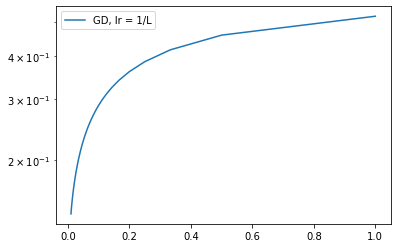

In [10]:
gd_iter_reciprocal = np.ndarray.tolist(np.reciprocal(np.array(history_gd_smoothL["iter"])))
plt.semilogy(gd_iter_reciprocal, history_gd_smoothL["difference"], label="GD, lr = 1/L")
plt.legend()

# Accelerated Gradient Descent for binary classification

In [11]:
def acc_gradient_descent_bc(X, y, lr, max_iter, trace=False):
    '''
    Accelerated Gradient Descent
    X: the full dataset matrix, shape = (n, d)
    y: the corresponding 0 or 1 labels, shape = (n)
    lr: learning rate (1/L in this project)
    max_iter: maximum number of iterations performed
    trace: for plotting graphs
    '''
    history = defaultdict(list) if trace else None  
    
    x_t = np.zeros(d)
    z_t = np.zeros(d)
    
    for current_iter in range(max_iter):
        gradient = compute_gradient_bc(X, y, x_t, n)
        y_t = x_t - lr * gradient
        z_t = z_t - lr * gradient * (current_iter+1) / 2
        x_t = y_t * (current_iter+1) / (current_iter+3) + z_t * 2 / (current_iter+3)
        if current_iter % 10 == 0:
            loss_value = loss(y, X, y_t)
            print('iteration=%i, loss:%.5f'%(
                    current_iter, loss_value))
        loss_value = loss(y, X, y_t)
        if trace:
            history['loss'].append(loss_value)
            history['difference'].append(loss_value-minimum)
            history['iter'].append(float(current_iter+1))
            history['gradients_computed'].append((current_iter+1)*n)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, y_t)))
    return history

In [12]:
history_accgd_smoothL = acc_gradient_descent_bc(X, y, 1/L, 100, trace=True)

iteration=0, loss:0.59869
iteration=10, loss:0.30174
iteration=20, loss:0.22866
iteration=30, loss:0.20280
iteration=40, loss:0.18808
iteration=50, loss:0.17698
iteration=60, loss:0.16770
iteration=70, loss:0.15983
iteration=80, loss:0.15322
iteration=90, loss:0.14765
training accuracy = 0.9777957206297941


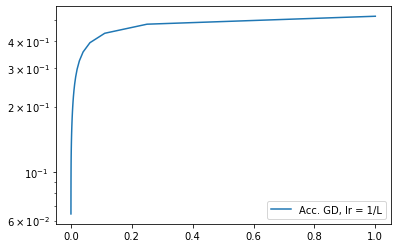

In [13]:
accgd_iter_reciprocal = np.ndarray.tolist(np.reciprocal(np.array(history_accgd_smoothL["iter"])**2))
plt.semilogy(accgd_iter_reciprocal, history_accgd_smoothL["difference"], label="Acc. GD, lr = 1/L")
plt.legend()

# Projected Gradient Descent for binary classification

In [14]:
def projection_on_L2(vector, threshold): # Projection of vector on a closed L2-ball
    if np.linalg.norm(vector) <= threshold:
        return vector
    else:
        return (threshold / np.linalg.norm(vector)) * vector

In [15]:
def proj_gradient_descent_bc(X, y, lr, threshold, max_iter, trace=False):
    '''
    Projected Gradient Descent
    X: the full dataset matrix, shape = (n, d)
    y: the corresponding 0 or 1 labels, shape = (n)
    lr: learning rate (1/L in this project)
    threshold: radius of the high-dimensional closed L2-ball, used for projection step
    max_iter: maximum number of iterations performed
    trace: for plotting graphs
    '''
    history = defaultdict(list) if trace else None
    
    x_t = np.zeros(d)
    
    for current_iter in range(max_iter):
        gradient = compute_gradient_bc(X, y, x_t, n)
        x_t = projection_on_L2(x_t - lr * gradient, threshold)
        if current_iter % 10 == 0:
            loss_value = loss(y, X, x_t)
            print('iteration=%i, loss:%.5f'%(
                    current_iter, loss_value))
        loss_value = loss(y, X, x_t)
        if trace:
            history['loss'].append(loss_value)
            history['difference'].append(loss_value-minimum)
            history['iter'].append(current_iter+1)
            history['gradients_computed'].append((current_iter+1)*n)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, x_t)))
    return history

In [16]:
threshold = 2
history_projgd_smoothL = proj_gradient_descent_bc(X, y, 1/L, threshold, 100, trace=True)

iteration=0, loss:0.59869
iteration=10, loss:0.35789
iteration=20, loss:0.30289
iteration=30, loss:0.27593
iteration=40, loss:0.26287
iteration=50, loss:0.26230
iteration=60, loss:0.26192
iteration=70, loss:0.26165
iteration=80, loss:0.26147
iteration=90, loss:0.26134
training accuracy = 0.973354864755753


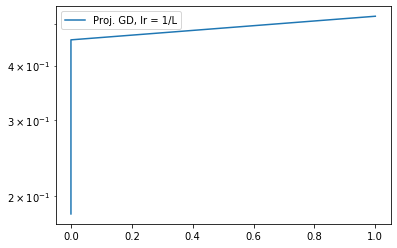

In [17]:
projgd_iter_reciprocal = np.ndarray.tolist(np.reciprocal(np.array(history_projgd_smoothL["iter"])))
plt.semilogy(projgd_iter_reciprocal, history_projgd_smoothL["difference"], label="Proj. GD, lr = 1/L")
plt.legend()

# Stochastic Gradient Descent for binary classification

In [18]:
history_sgd_smoothL = stochastic_gradient_descent_bc(X, y, 1/L, 15000, batch_size, trace=True)

iteration=0, loss:0.63306
iteration=100, loss:0.21767
iteration=200, loss:0.19695
iteration=300, loss:0.18448
iteration=400, loss:0.17703
iteration=500, loss:0.17095
iteration=600, loss:0.16685
iteration=700, loss:0.16265
iteration=800, loss:0.15949
iteration=900, loss:0.15650
iteration=1000, loss:0.15431
iteration=1100, loss:0.15160
iteration=1200, loss:0.14945
iteration=1300, loss:0.14732
iteration=1400, loss:0.14560
iteration=1500, loss:0.14382
iteration=1600, loss:0.14272
iteration=1700, loss:0.14100
iteration=1800, loss:0.13965
iteration=1900, loss:0.13849
iteration=2000, loss:0.13706
iteration=2100, loss:0.13626
iteration=2200, loss:0.13626
iteration=2300, loss:0.13502
iteration=2400, loss:0.13411
iteration=2500, loss:0.13293
iteration=2600, loss:0.13147
iteration=2700, loss:0.13074
iteration=2800, loss:0.13000
iteration=2900, loss:0.12936
iteration=3000, loss:0.12904
iteration=3100, loss:0.12835
iteration=3200, loss:0.12779
iteration=3300, loss:0.12709
iteration=3400, loss:0.125

Lets plot

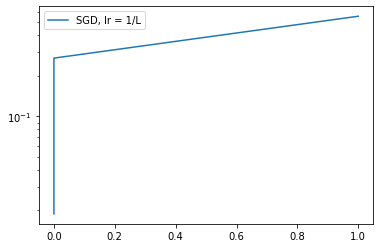

In [19]:
sgd_iter_reciprocal = np.ndarray.tolist(np.reciprocal(np.array(history_sgd_smoothL["iter"])))
plt.semilogy(sgd_iter_reciprocal, history_sgd_smoothL["difference"], label="SGD, lr = 1/L")
plt.legend()

# Comparing convergence speed and running time of different algorithms

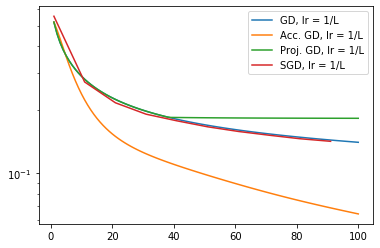

In [20]:
plt.semilogy(history_gd_smoothL["iter"], history_gd_smoothL["difference"], label="GD, lr = 1/L")
plt.semilogy(history_accgd_smoothL["iter"], history_accgd_smoothL["difference"], label="Acc. GD, lr = 1/L")
plt.semilogy(history_projgd_smoothL["iter"], history_projgd_smoothL["difference"], label="Proj. GD, lr = 1/L")
plt.semilogy(history_sgd_smoothL["iter"][:10], history_sgd_smoothL["difference"][:10], label="SGD, lr = 1/L")
plt.legend()

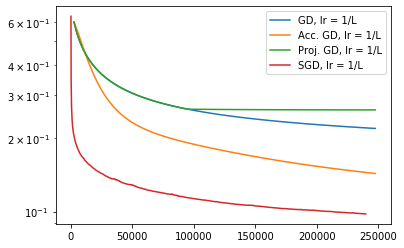

In [21]:
plt.semilogy(history_gd_smoothL["gradients_computed"], history_gd_smoothL["loss"], label="GD, lr = 1/L")
plt.semilogy(history_accgd_smoothL["gradients_computed"], history_accgd_smoothL["loss"], label="Acc. GD, lr = 1/L")
plt.semilogy(history_projgd_smoothL["gradients_computed"], history_projgd_smoothL["loss"], label="Proj. GD, lr = 1/L")
plt.semilogy(history_sgd_smoothL["gradients_computed"], history_sgd_smoothL["loss"], label="SGD, lr = 1/L")
plt.legend()